![](https://pm4py.fit.fraunhofer.de/static/assets/images/pm4py-site-logo-padded.png)

# 0. Introduction

**Process:**  
By process we mean a collection of discrete events (activities) in order to achieve a certain goal.

**Process mining:**  
A set of techniques used for obtaining knowledge of and extracting insights from processes by the means of analyzing the event data, generated during the execution of the process. The end goal of process mining is to discover, model, monitor, and optimize the underlying processes.

**Potential benefits of process mining:**
- Process discovery — Converting an event log into a process model.
- Conformance checking — Investigating the differences between the model and what happens in real life. This way the companies can identify deviations from the model and determine their severity/cost.
- Throughput analysis/bottleneck detection — Accounting for the intensity of events’ execution (measured by time spent to complete a particular event) in order to determine potential bottlenecks. This kind of analysis can be used to improve time-related KPIs by minimizing throughput/overhead time.

**Event log:**   
In order to carry out process mining, a dataset must contain (at least) the following 3 types of information:
- Case ID — A unique identifier of an entity going through the process. A common example could be the user’s unique ID, although, many possibilities are valid (it depends on the use case).
- Event — A step of the process, any activity that is a part of the process being analyzed.
- Timestamp — Used for performance evaluation and determining the order of events, can be the time when the user entered/exited the given event (or both actually).

**Petri net:**  
A Petri net - also known as a place/transition (PT) net - consists of _places_, _transitions_, and _arcs_ (a.k.a. _flow relations_). Arcs run from a place to a transition or vice versa, never between places or between transitions. The places from which an arc runs to a transition are called the input places of the transition; the places to which arcs run from a transition are called the output places of the transition. 

# 1. Setup

## 1.1 Packages

In [1]:
# python ######################################################################
import sys
import os
import datetime

# basics ######################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# widgets #####################################################################
import ipywidgets as widgets
from ipywidgets import interact

# process mining ##############################################################
import pm4py

# object.log
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

# object.conversion
from pm4py.objects.conversion.dfg import converter as dfg_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter

# algo.discovery
from pm4py.algo.discovery.alpha import variants
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# algo.filtering
from pm4py.algo.filtering.log.auto_filter.auto_filter import apply_auto_filter

# algo.conformance
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
# vizualization
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# statistics
from pm4py.statistics.traces.log import case_statistics

# util
from pm4py.util import vis_utils

## 1.2 Environment

In [2]:
print(f'platform     {sys.platform}')
print(f'environment  {sys.prefix}')
print(f'python       {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')

platform     linux
environment  /home/rene/miniconda3/envs/processmining
python       3.8.5


## 1.3 Versions

In [3]:
pd.DataFrame(
    [
        ['pandas', pd.__version__], 
        ['numpy ', np.__version__], 
        ['matplotlib', sys.modules['matplotlib'].__version__], 
        ['seaborn', sns.__version__],
        ['ipywidgets', sys.modules['ipywidgets'].__version__],
        ['pm4py', pm4py.__version__],
    ], 
    columns = ['package', 'version']
).set_index('package')

,version
package,
pandas,1.2.0
numpy,1.19.2
matplotlib,3.3.2
seaborn,0.11.1
ipywidgets,7.6.3
pm4py,2.2.0


## 1.4 Directories

In [4]:
directories = ['log', 'output']

In [5]:
for directory in directories:
    if not os.path.isdir(directory):
        os.mkdir(directory)

## 1.5 Setting

In [6]:
pd.set_option('display.max_rows', 50)

In [7]:
sns.set_theme()

## 1.6 Functions

In [8]:
def dfg_performance_matrix(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str, 
    duration: str ='h'
) -> pd.DataFrame:
    
    """
    Return a directly-follows graph duration matrix based on the traces in the event log.
    Row events (i.e. the index) are events 'from' and column events are the events 'to'.
    By default duration is set to hours (h). Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    # event log
    log = event_log[[case_var, event_var, timestamp_var]]
    
    # initiate matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for group in groups:
        event = group[1].sort_values(timestamp_var)\
        .rename(columns = {event_var:'event_from', timestamp_var:'time_begin'})
        event['event_to'] = event['event_from'].shift(-1)
        event['time_end'] = event['time_begin'].shift(-1)
        event['duration'] = (event['time_end'] - event['time_begin']) / np.timedelta64(1, duration)
        event.dropna(inplace = True)
        
        # loop through traces
        for row in event.itertuples(index = False):
            matrix.at[row.event_from, row.event_to] = \
            np.nansum([matrix.at[row.event_from, row.event_to], row.duration])
    
    return matrix.astype(float)

In [9]:
def dfg_frequency_matrix(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str
) -> pd.DataFrame:
    
    """
    Return a directly-follows graph frequency matrix based on the traces in the event log.
    Row events (i.e. the index) are events 'from' and column events are the events 'to'.
    """
    
    # event log
    log = event_log[[case_var, event_var, timestamp_var]]
    
    # initiate matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events).fillna(0)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for group in groups:
        event = group[1].sort_values(timestamp_var)\
        .drop([case_var, timestamp_var], axis = 1)\
        .rename(columns = {event_var:'event_from'})
        event['event_to'] = event['event_from'].shift(-1)
        event.dropna(inplace = True)
        
        # loop through traces
        for trace in event.itertuples(index = False):
            matrix.at[trace.event_from, trace.event_to] += 1
                
    return matrix.replace(0, np.nan)

In [10]:
def dfg_frequency_table(dfg_frequency_matrix: pd.DataFrame) -> pd.DataFrame:
    
    """
    Returns an directly-follows graph frequency table
    """
    
    arcs = list()
    
    for row in dfg_frequency_matrix.index:
        for col in dfg_frequency_matrix.columns:
            if not np.isnan(dfg_frequency_matrix.at[row, col]):
                arcs.append((row, col, dfg_frequency_matrix.at[row, col]))
    
    arc_freq = pd.DataFrame(arcs, columns = ['event_from', 'event_to', 'frequency'])\
    .set_index(['event_from', 'event_to'])
    
    return arc_freq

In [11]:
def activity_duration(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str, 
    duration: str ='h'
) -> pd.DataFrame:
    
    """
    Returns a dataframe with activity durations (i.e. 'arc' performance decorators).
    By default duration is set to hours (h).
    Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    data = dict()
    groups = log_csv.groupby(case_var)
    for group in groups:
        arc = group[1].sort_values(timestamp_var)\
        .rename(columns = {event_var:'event_from', timestamp_var:'time_from'})
        arc['event_to'] = arc['event_from'].shift(-1)
        arc['time_to'] = arc['time_from'].shift(-1)
        arc.dropna(inplace = True)
        duration_var = f'duration ({duration})'
        arc[duration_var] = (arc['time_to'] - arc['time_from']) / np.timedelta64(1, duration)
        data[group[0]] = arc[[case_var, 'event_from', 'event_to', 'time_from', 'time_to', duration_var]]
    return pd.concat(data.values()).set_index(case_var)

# 2. Data Prepatation

## 2.1 Read Data

In [12]:
log_csv = pd.read_csv('data/running-example.csv', sep=';')

## 2.2 Convert Data

In [13]:
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

## 2.3 Explore Data

In [14]:
# Shape
log_csv.shape

(42, 5)

In [15]:
# Check NA-values
log_csv.isna().sum()

case_id      0
activity     0
timestamp    0
costs        0
resource     0
dtype: int64

In [16]:
# Info
log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   case_id    42 non-null     int64              
 1   activity   42 non-null     object             
 2   timestamp  42 non-null     datetime64[ns, UTC]
 3   costs      42 non-null     int64              
 4   resource   42 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 1.8+ KB


In [17]:
# Sample
log_csv.sample(frac=.25)

,case_id,activity,timestamp,costs,resource
36,5,reject request,2011-01-24 13:56:00+00:00,200,Mike
32,5,reinitiate request,2011-01-20 11:48:00+00:00,200,Sara
28,5,reinitiate request,2011-01-11 15:18:00+00:00,200,Sara
4,3,reinitiate request,2011-01-06 11:18:00+00:00,200,Sara
7,3,decide,2011-01-09 08:55:00+00:00,200,Sara
17,1,decide,2011-01-06 10:18:00+00:00,200,Sara
0,3,register request,2010-12-30 13:32:00+00:00,50,Pete
9,2,register request,2010-12-30 10:32:00+00:00,50,Mike
33,5,examine casually,2011-01-21 08:06:00+00:00,400,Sue
21,6,check ticket,2011-01-07 15:22:00+00:00,100,Mike


In [18]:
# Unique values
pd.DataFrame(
    {
        'variable': log_csv.columns, 
        'unique values': [log_csv[col].nunique() for col in log_csv.columns],
        'fraction': [round(log_csv[col].nunique() / log_csv.shape[0], 2) for col in log_csv.columns], 
    }
).set_index('variable')

,unique values,fraction
variable,,
case_id,6,0.14
activity,8,0.19
timestamp,41,0.98
costs,4,0.10
resource,6,0.14


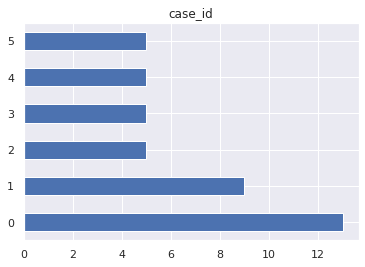

In [19]:
# Value counts: case_id
log_csv.case_id.value_counts().reset_index(drop=True).plot(y='case_id', kind='barh', title='case_id')
plt.show()

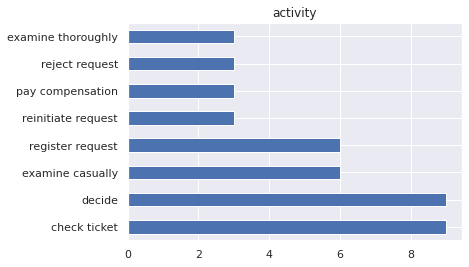

In [20]:
# Value counts: activity
log_csv.activity.value_counts().plot(y='activity', kind='barh', title='activity')
plt.show()

In [21]:
# Unique values: timestamp
log_csv.timestamp.nunique()

41

In [22]:
# Multiple occurences: timestamp
log_csv.timestamp.value_counts()[log_csv.timestamp.value_counts() > 1]

2011-01-06 14:02:00+00:00    2
Name: timestamp, dtype: int64

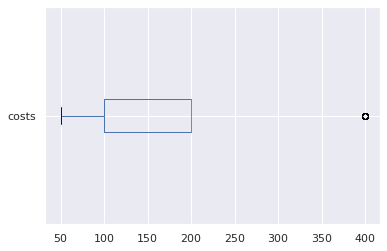

In [23]:
# Value distrubution: costs
log_csv.costs.plot(kind='box', vert=False)
plt.show()

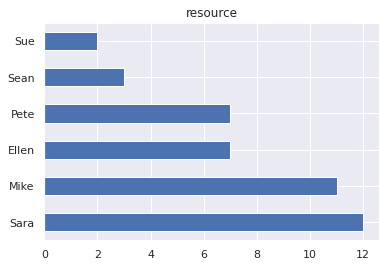

In [24]:
# Value counts: resource
log_csv.resource.value_counts().plot(y='resource', kind='barh', title='resource')
plt.show()

## 2.4 Analyse Data

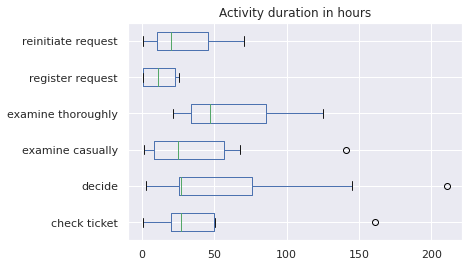

In [25]:
# Boxplot activity duration
activity_duration(log_csv, 'case_id', 'activity', 'timestamp')\
.loc[:, ['event_from', 'event_to', 'duration (h)']]\
.reset_index()\
.pivot(columns='event_from', values='duration (h)')\
.plot(kind='box', vert=False, title='Activity duration in hours')
plt.show()

In [26]:
# Directly-Follows Graph frequency and performance (in hours) table
df = pd.merge(
    dfg_frequency_table(
        dfg_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp'))\
    .reset_index(),
    activity_duration(log_csv, 'case_id', 'activity', 'timestamp')\
    .loc[:, ['event_from', 'event_to', 'duration (h)']]\
    .groupby(by = ['event_from', 'event_to']).mean('duration (h)')\
    .reset_index(),
    left_on = ['event_from', 'event_to'],
    right_on = ['event_from', 'event_to']
).rename(columns = {'duration (h)':'average_duration'})

df['average_duration'] = df['average_duration'].apply(lambda x: np.round(x, decimals=2))
df['frequency'] = df['frequency'].astype(int)
df['total_duration'] = df['frequency'] * df['average_duration']

df.sort_values(['total_duration', 'average_duration', 'frequency'], ascending=False)

,event_from,event_to,frequency,average_duration,total_duration
9,decide,pay compensation,3,142.82,428.46
6,check ticket,decide,6,50.54,303.24
4,examine casually,decide,2,104.28,208.56
14,examine thoroughly,check ticket,2,85.86,171.72
10,decide,reject request,3,42.84,128.52
12,reinitiate request,check ticket,1,70.25,70.25
8,decide,reinitiate request,3,18.44,55.32
3,examine casually,check ticket,4,13.32,53.28
5,check ticket,examine casually,2,25.68,51.36
0,register request,examine casually,3,8.96,26.88


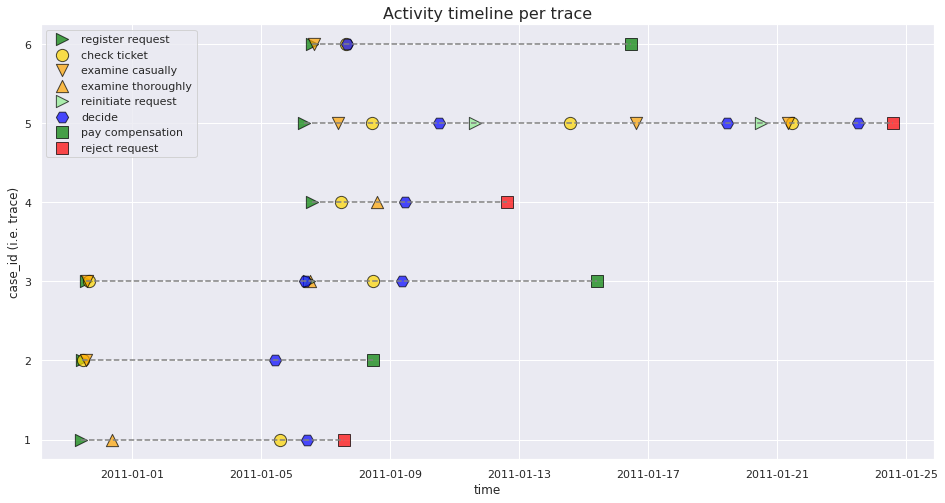

In [27]:
# Visualize eventlog ##########################################################

# Settings
activity = {
    'register request': ('>', 'green'), 
    'check ticket': ('o', 'gold'), 
    'examine casually': ('v', 'orange'), 
    'examine thoroughly': ('^', 'orange'), 
    'reinitiate request': ('>', 'lightgreen'), 
    'decide': ('H', 'blue'), 
    'pay compensation': ('s', 'green'), 
    'reject request': ('s', 'red'),
}

# Figure
fig, ax = plt.subplots(figsize=(16, 8))

# Timelines
for timeline in log_csv.groupby('case_id').agg(time_start = ('timestamp', min), 
                                               time_end = ('timestamp', max)
                                              ).reset_index().itertuples(index=False):
    plt.hlines(timeline.case_id, timeline.time_start, timeline.time_end, 
               colors = 'grey', linestyles = 'dashed')

# Activities
for act in activity.keys():
    ax.scatter(log_csv.loc[log_csv.activity == act, 'timestamp'], 
               log_csv.loc[log_csv.activity == act, 'case_id'],
               marker = activity[act][0],
               color = activity[act][1], 
               s = 150, 
               alpha = .7,
               label = act,
               edgecolors = 'black',
              )
    
ax.set_title('Activity timeline per trace', fontsize=16)
ax.set_xlabel('time')
ax.set_ylabel('case_id (i.e. trace)')
ax.legend()
ax.grid(True)

plt.show()

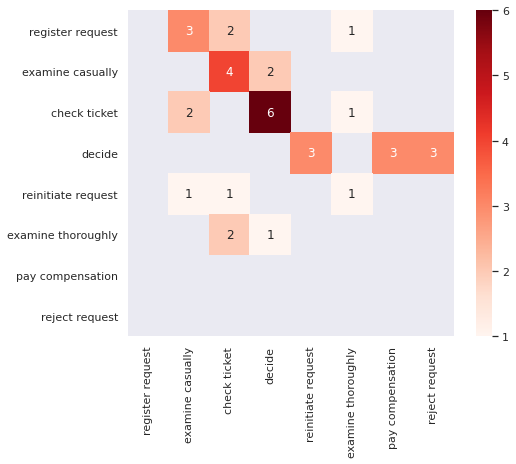

In [28]:
# Directly-Follows Graph frequency heatmap
dfg_freq_matrix = dfg_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp')
sns.set(rc={'figure.figsize':(8, 6)})
sns.heatmap(dfg_freq_matrix, annot=True, fmt='.0f', cmap='Reds', square=True)
plt.show()

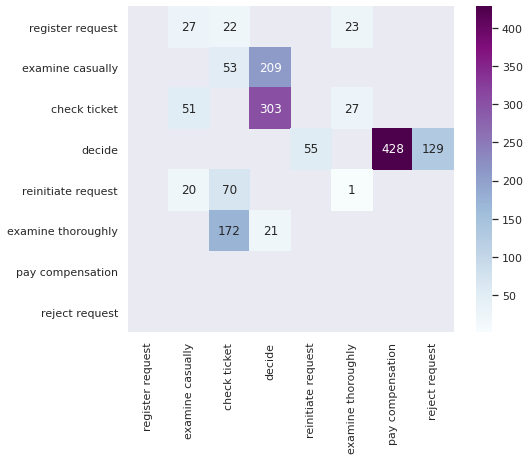

In [29]:
# Directly-Follows Graph total duration heapmap (in hours)
dfg_perf_matrix = dfg_performance_matrix(log_csv, 'case_id', 'activity', 'timestamp', duration='h')
sns.set(rc={'figure.figsize':(8, 6)})
sns.heatmap(dfg_perf_matrix, annot=True, fmt='.0f', cmap='BuPu', square=True)
plt.show()

# 3. Event Log

## 3.1 Create Event Log

In [30]:
event_log = pm4py.format_dataframe(
    log_csv,
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

## 3.2 View Event Log

In [31]:
event_log.head(7)

,case:concept:name,concept:name,time:timestamp,costs,resource,@@index
14,1,register request,2010-12-30 10:02:00+00:00,50,Pete,14
15,1,examine thoroughly,2010-12-31 09:06:00+00:00,400,Sue,15
16,1,check ticket,2011-01-05 14:12:00+00:00,100,Mike,16
17,1,decide,2011-01-06 10:18:00+00:00,200,Sara,17
18,1,reject request,2011-01-07 13:24:00+00:00,200,Pete,18
9,2,register request,2010-12-30 10:32:00+00:00,50,Mike,9
10,2,check ticket,2010-12-30 11:12:00+00:00,100,Mike,10


In [32]:
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)

In [33]:
print(f'Start activities: {start_activities}')
print(f'End activities  : {end_activities}')

Start activities: {'register request': 6}
End activities  : {'pay compensation': 3, 'reject request': 3}


## 3.3. Export Event Log (to XES)

In [34]:
xes_exporter.apply(event_log, 'log/running-example.xes')

exporting log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

## 3.4. Import Event Log (from XES)

In [35]:
log = xes_importer.apply('log/running-example.xes')

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

## 3.5 Event Log (XES)

In [36]:
# EventLog
type(log)

pm4py.objects.log.log.EventLog

In [37]:
# Trace
type(log[0])

pm4py.objects.log.log.Trace

In [38]:
# Trace
type(log[0][0])

pm4py.objects.log.log.Event

In [39]:
# concept:name (i.e case_id) for each trace
[trace.attributes['concept:name'] for trace in log]

['1', '2', '3', '4', '5', '6']

In [40]:
# Overview traces from XES
for trace in log:
    print('== TRACE: {} =================================================='\
          .format(trace.attributes['concept:name'])
         )
    for event in trace:
        print('{:>18}:  {:>3}  |  {:>5}  |  {}  |  {:>2}'.format(
            event.get('concept:name'), 
            event.get('costs'), 
            event.get('resource'), 
            event.get('time:timestamp').strftime('%Y-%m-%d %H:%M'), 
            event.get('@@index')
        ))
    print()

== TRACE: 1 ==================================================
  register request:   50  |   Pete  |  2010-12-30 10:02  |  14
examine thoroughly:  400  |    Sue  |  2010-12-31 09:06  |  15
      check ticket:  100  |   Mike  |  2011-01-05 14:12  |  16
            decide:  200  |   Sara  |  2011-01-06 10:18  |  17
    reject request:  200  |   Pete  |  2011-01-07 13:24  |  18

== TRACE: 2 ==================================================
  register request:   50  |   Mike  |  2010-12-30 10:32  |   9
      check ticket:  100  |   Mike  |  2010-12-30 11:12  |  10
  examine casually:  400  |   Sean  |  2010-12-30 13:16  |  11
            decide:  200  |   Sara  |  2011-01-05 10:22  |  12
  pay compensation:  200  |  Ellen  |  2011-01-08 11:05  |  13

== TRACE: 3 ==================================================
  register request:   50  |   Pete  |  2010-12-30 13:32  |   0
  examine casually:  400  |   Mike  |  2010-12-30 14:06  |   1
      check ticket:  100  |  Ellen  |  2010-12-30 15:

In [41]:
# Start activities
pm4py.get_start_activities(log)

{'register request': 6}

In [42]:
# End activities
pm4py.get_end_activities(log)

{'reject request': 3, 'pay compensation': 3}

In [43]:
# Filter on end activity 'pay compensation'
pay_compensation = pm4py.filter_end_activities(log, {'pay compensation'})
pay_compensation

[{'attributes': {'concept:name': '2'}, 'events': [{'concept:name': 'register request', 'time:timestamp': datetime.datetime(2010, 12, 30, 10, 32, tzinfo=datetime.timezone.utc), 'costs': 50, 'resource': 'Mike', '@@index': 9}, '..', {'concept:name': 'pay compensation', 'time:timestamp': datetime.datetime(2011, 1, 8, 11, 5, tzinfo=datetime.timezone.utc), 'costs': 200, 'resource': 'Ellen', '@@index': 13}]}, '....', {'attributes': {'concept:name': '6'}, 'events': [{'concept:name': 'register request', 'time:timestamp': datetime.datetime(2011, 1, 6, 14, 2, tzinfo=datetime.timezone.utc), 'costs': 50, 'resource': 'Mike', '@@index': 19}, '..', {'concept:name': 'pay compensation', 'time:timestamp': datetime.datetime(2011, 1, 16, 10, 47, tzinfo=datetime.timezone.utc), 'costs': 200, 'resource': 'Mike', '@@index': 23}]}]

In [44]:
# Traces (i.e. case_id) with and activity 'pay compensation'
for trace in pay_compensation:
    print(trace.attributes['concept:name'])

2
3
6


In [45]:
# Filter methods
[_ for _ in dir(pm4py) if _.startswith('filter')]

['filter_attribute_values',
 'filter_directly_follows_relation',
 'filter_end_activities',
 'filter_event_attribute_values',
 'filter_eventually_follows_relation',
 'filter_log',
 'filter_start_activities',
 'filter_time_range',
 'filter_trace',
 'filter_trace_attribute',
 'filter_trace_attribute_values',
 'filter_variants',
 'filter_variants_percentage',
 'filtering']

In [46]:
# Filter on traces that did start and end in 2011
start_datetime = datetime.datetime(2011, 1, 1, 0, 0, 0, 0)
end_datetime = datetime.datetime(2011, 12, 31, 23, 59, 59, 999999)
log_2011 = pm4py.filter_time_range(log, start_datetime, end_datetime, mode='traces_contained')

# Print case_id's (traces) in 20111
for trace in log_2011:
    print(trace.attributes['concept:name'])

4
5
6


# 4. Process Dicovery

Alpha | Alpha+ | Heuristic | Inductive
------ | ------ | ------ | ------ 
Cannot handle loops of length one and length two | Can handle loops of length one and length two | Takes frequency into account | Can handle invisible tasks
Invisible and duplicated tasks cannot be discovered | Invisible and duplicated tasks cannot be discovered | Detects short loops | Model is sound
Discovered model might not be sound | Discovered model might not be sound | Does not guarantee a sound model | Most used process mining algorithm
Weak against noise | Weak against noise | |

## 4.1 Alpha Miner

The alpha miner is one of the most known Process Discovery algorithm and is able to find:

- A [Petri net](https://en.wikipedia.org/wiki/Petri_net) model where all the transitions are visible and unique and correspond to classified events (for example, to activities).
- An initial marking that describes the status of the Petri net model when an execution starts.
- A final marking that describes the status of the Petri net model when an execution ends.

### 4.1.1 Alpha Miner

- **Cannot** handle loops of length one and length two
- Invisible and duplicated tasks cannot be discovered
- Discovered model might not be sound
- Weak against noise

```python
# Simplified Interface
petri_net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
pm4py.save_vis_petri_net(petri_net, initial_marking, final_marking, 
                         file_path='output/alpha.png') # svg
pm4py.view_petri_net(petri_net, initial_marking, final_marking, 
                     format='png')
```

#### Default

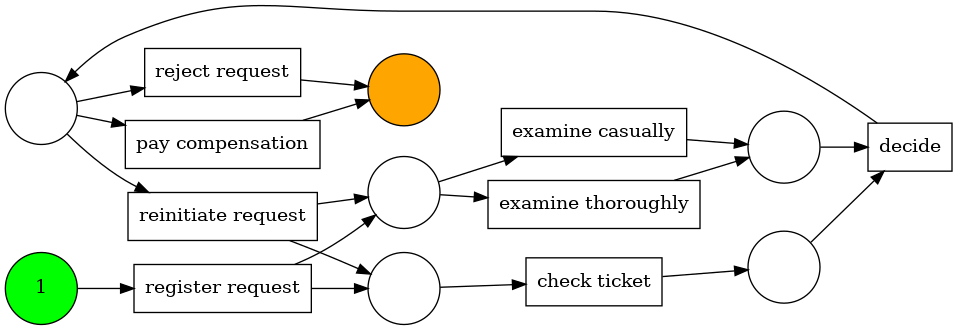

In [47]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.classic)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_classic_petri_default.png')

# View
pn_visualizer.view(gviz)

#### Performance

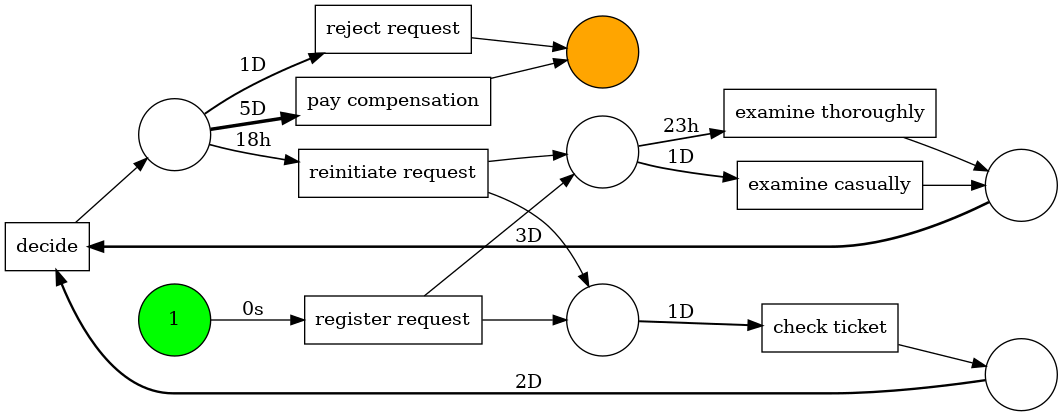

In [48]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.classic)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.PERFORMANCE,
                           log=log)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_classic_petri_performance.png')

# View
pn_visualizer.view(gviz)

#### Frequency

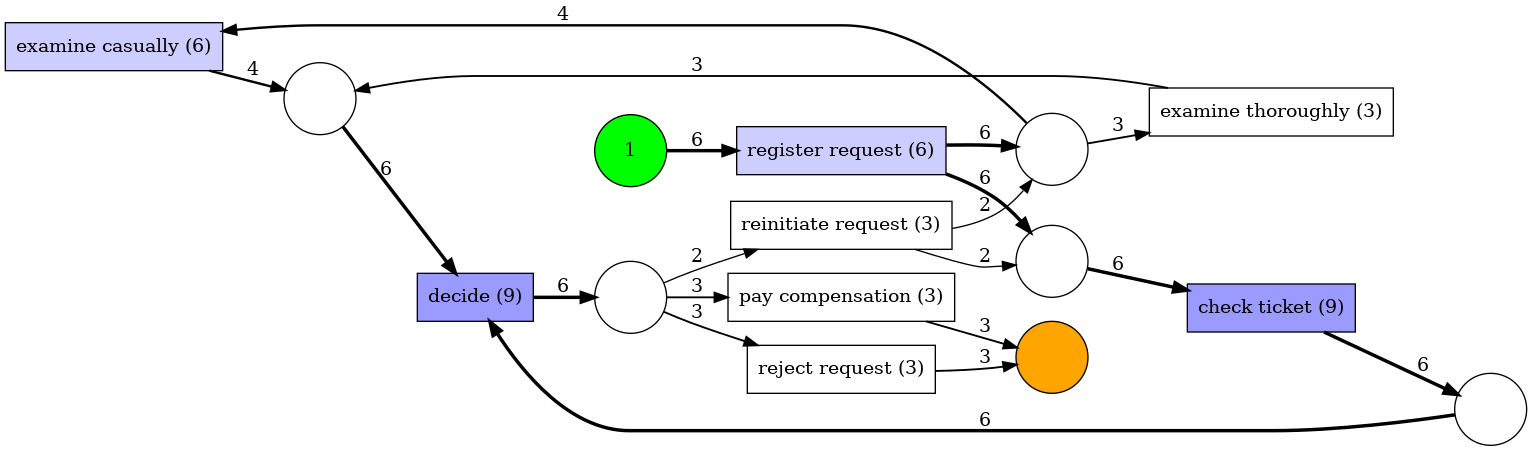

In [49]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.classic)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=log)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_classic_petri_frequency.png')

# View
pn_visualizer.view(gviz)

### 4.1.2 Alpha+ Miner

- **Can** handle loops of length one and length two
- Invisible and duplicated tasks cannot be discovered
- Discovered model might not be sound
- Weak against noise

```python
# Simplified Interface
petri_net, initial_marking, final_marking = pm4py.discover_petri_net_alpha_plus(log)
pm4py.save_vis_petri_net(petri_net, initial_marking, final_marking, 
                         file_path='output/alpha_plus.png') # svg
pm4py.view_petri_net(petri_net, initial_marking, final_marking, 
                     format='png')
```

#### Default

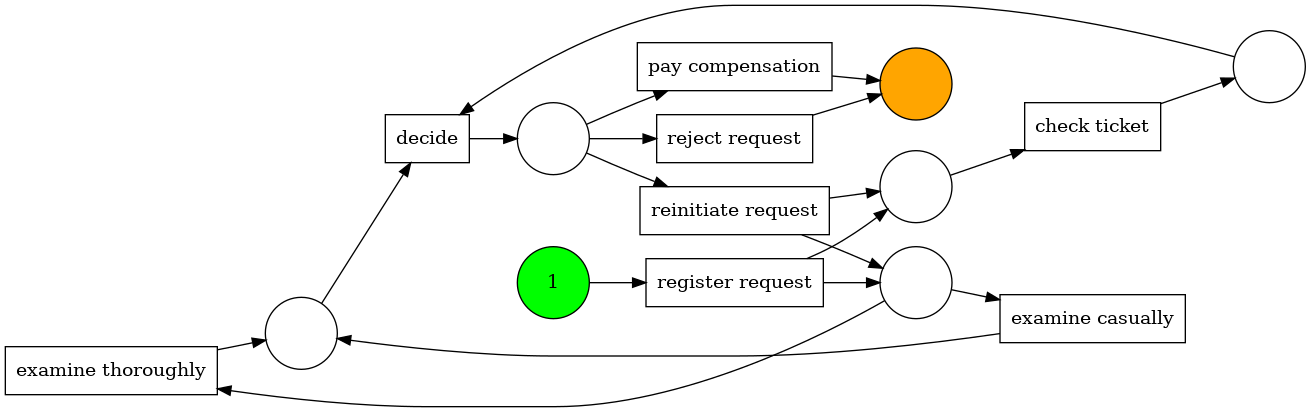

In [50]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.plus)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_plus_petri_default.png')

# View
pn_visualizer.view(gviz)

#### Performance

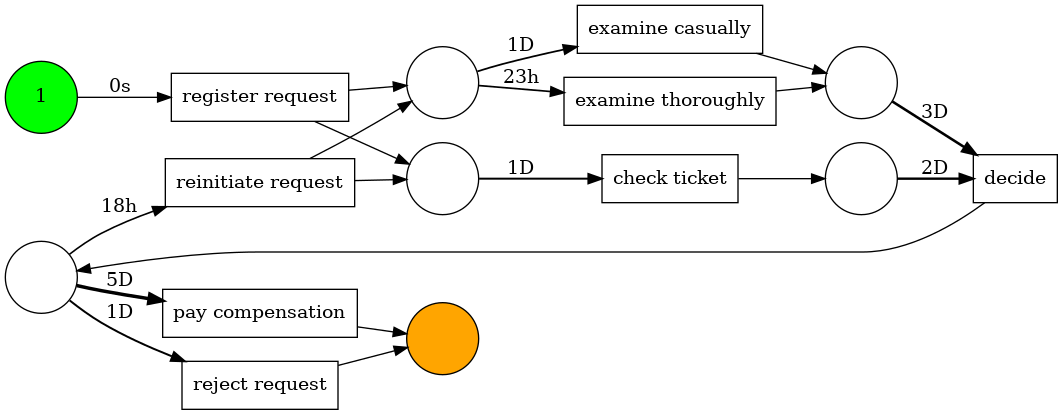

In [51]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.plus)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.PERFORMANCE,
                           log=log)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_plus_petri_performance.png')

# View
pn_visualizer.view(gviz)

#### Frequency

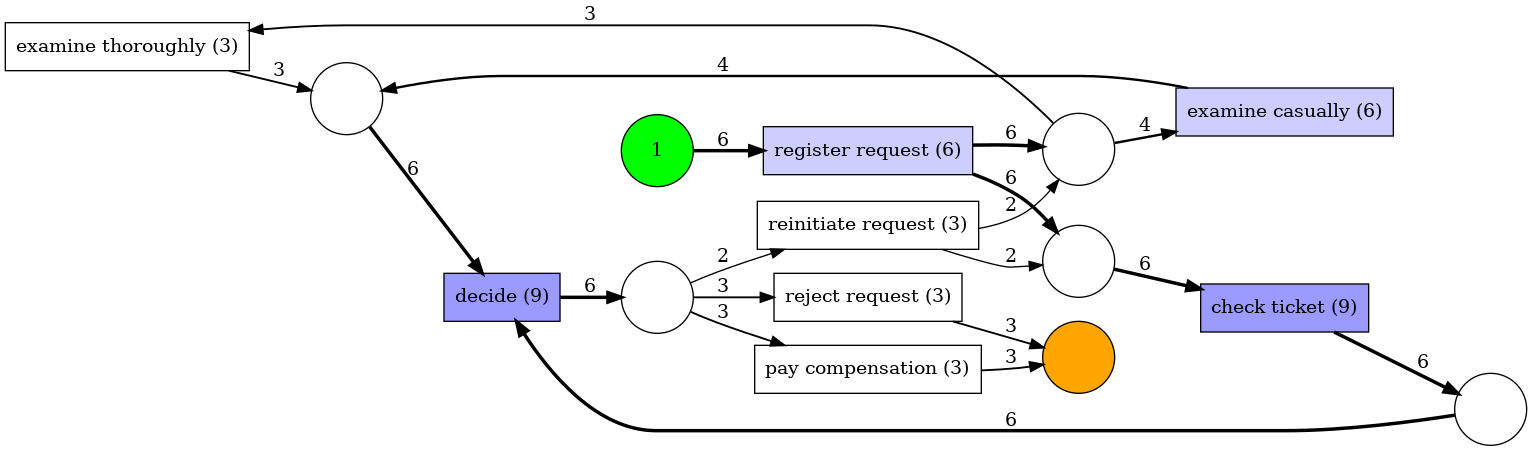

In [52]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.plus)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=log)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_plus_petri_frequency.png')

# View
pn_visualizer.view(gviz)

## 4.2 Heuristic Miner

- Takes frequency into account
- Detects short loops
- Does not guarantee a sound model

```python
# Simplified Interface
heu_net = pm4py.discover_heuristics_net(
    log, dependency_threshold=0.5, 
    and_threshold=0.65, 
    loop_two_threshold=0.5
)
pm4py.save_vis_heuristics_net(heu_net, file_path='output/heuristics_net.png') 
pm4py.view_heuristics_net(heu_net)
```

### 4.2.1 Parameters

#### Implicit default parameters

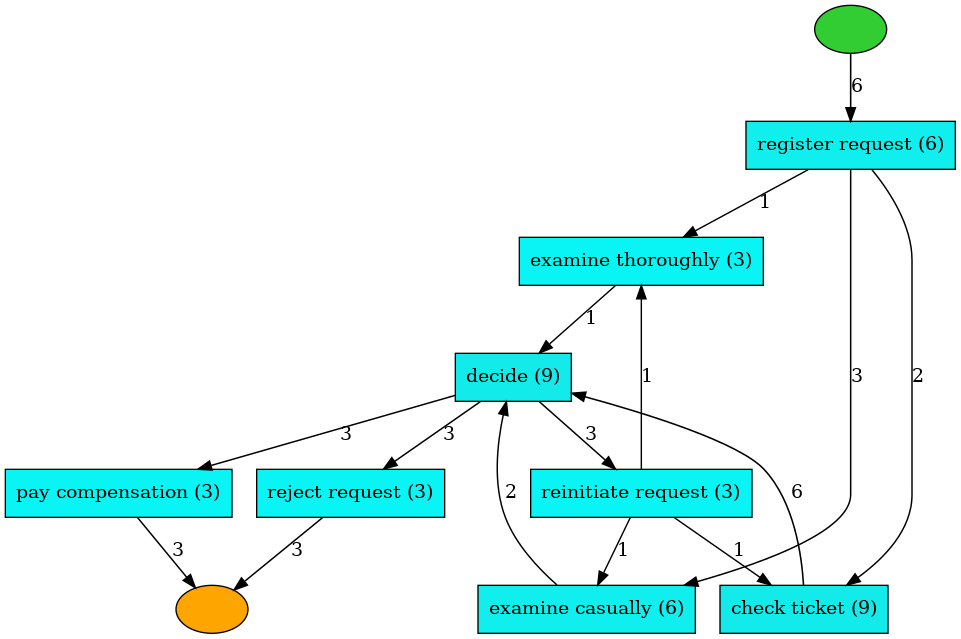

In [53]:
# Miner
heu_net = heuristics_miner.apply_heu(log)

# GraphViz
gviz = hn_visualizer.apply(heu_net)

# View
hn_visualizer.view(gviz)

#### Explicit default parameters

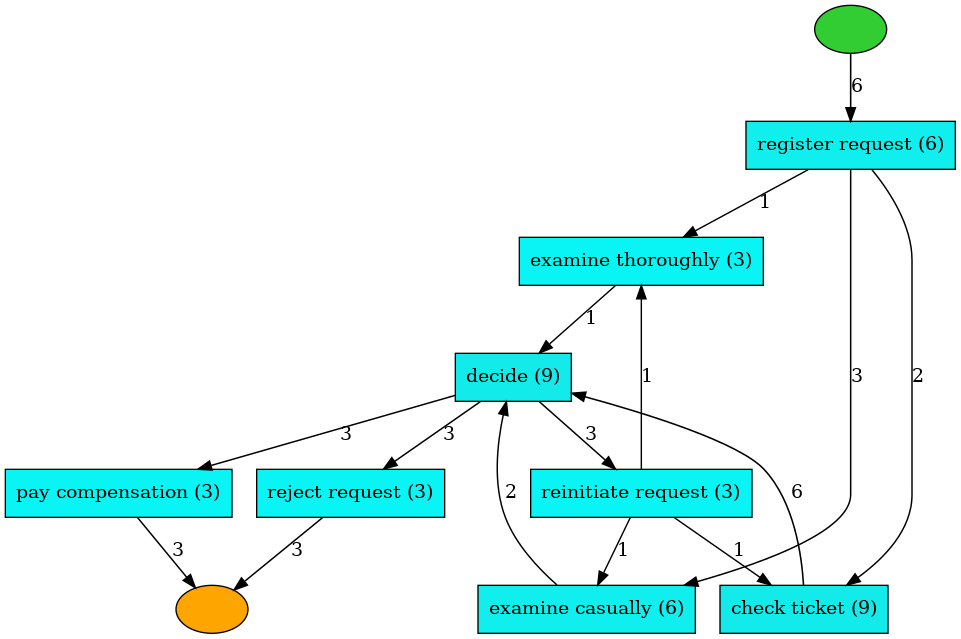

In [54]:
# Parameters
parameters = heuristics_miner.Variants.CLASSIC.value.Parameters

# Miner
heu_net = heuristics_miner.apply_heu(
    log,
    variant=heuristics_miner.Variants.CLASSIC, 
    parameters={
        parameters.DEPENDENCY_THRESH: 0.5, 
        parameters.AND_MEASURE_THRESH: 0.65,
        parameters.LOOP_LENGTH_TWO_THRESH: 0.5
    }
)

# GraphViz
gviz = hn_visualizer.apply(heu_net)

# View
hn_visualizer.view(gviz)

#### Interactive Heuristics Miner

In [55]:
def heuristics_tree(dependency_threshold, and_threshold, loop_two_threshold):
    # Parameters
    parameters = heuristics_miner.Variants.CLASSIC.value.Parameters

    # Miner
    heu_net = heuristics_miner.apply_heu(
        log,
        variant=heuristics_miner.Variants.CLASSIC, 
        parameters={
            parameters.DEPENDENCY_THRESH: dependency_threshold, 
            parameters.AND_MEASURE_THRESH: and_threshold,
            parameters.LOOP_LENGTH_TWO_THRESH: loop_two_threshold
        }
    )

    # GraphViz
    gviz = hn_visualizer.apply(heu_net)
    
    # Save
    hn_visualizer.save(gviz, 'output/temp.png')
    
    # View
    vis_utils.view_image_in_jupyter('output/temp.png')


interact(
    heuristics_tree, 
    dependency_threshold = widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01, description='Dependency:', 
        disabled=False, continuous_update=False, orientation='horizontal', 
        readout=True, readout_format='.2f'
    ),
    and_threshold = widgets.FloatSlider(
        value=0.65, min=0, max=1, step=0.01, description='And:', 
        disabled=False, continuous_update=False, orientation='horizontal', 
        readout=True, readout_format='.2f'
    ),
    loop_two_threshold = widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01, description='Loop Two:', 
        disabled=False, continuous_update=False, orientation='horizontal', 
        readout=True, readout_format='.2f'
    ),
)


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Dependency:', max=1.0, step…

<function __main__.heuristics_tree(dependency_threshold, and_threshold, loop_two_threshold)>

### 4.4.2 Convert "Heuristic Miner" to "Petri Net"

#### Performance

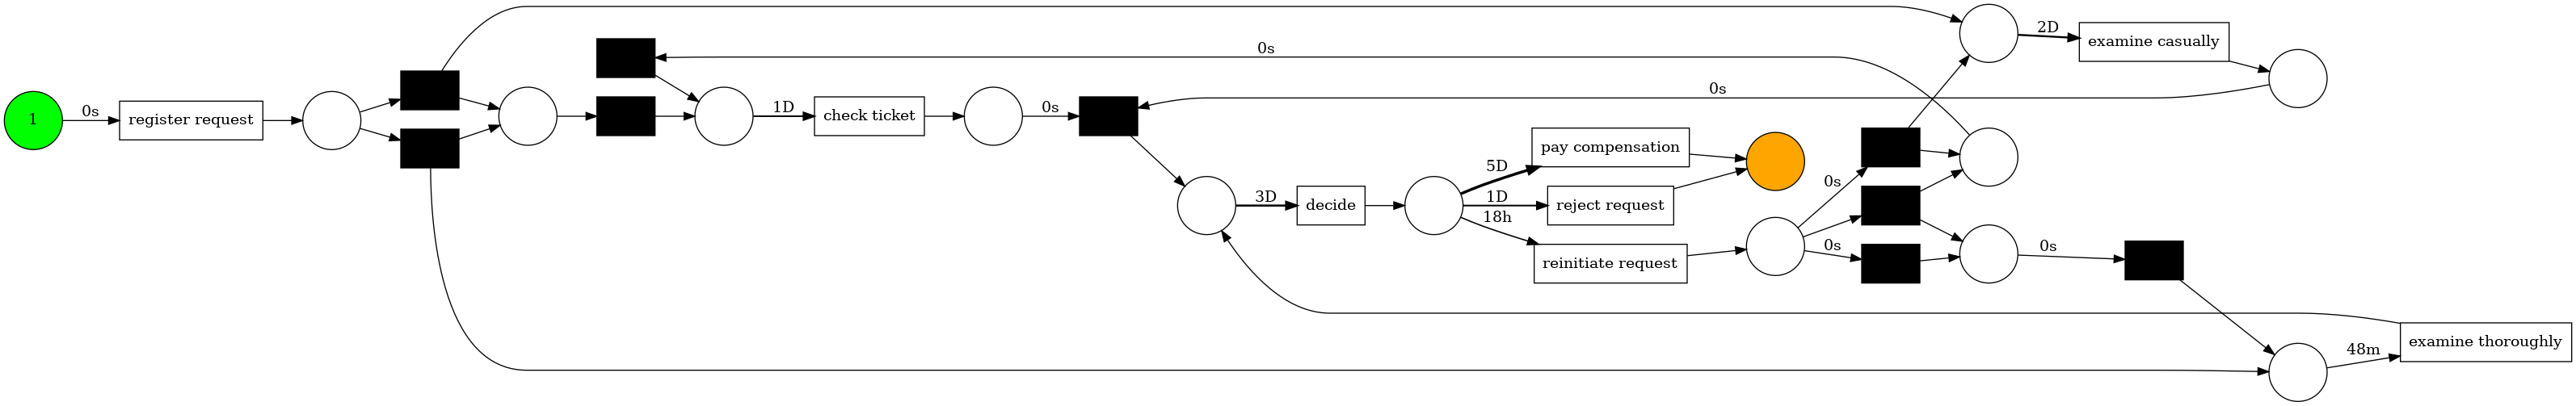

In [56]:
# Miner
petri_net, initial_marking, final_marking = heuristics_miner.apply(log)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.PERFORMANCE, 
                           log=log)

# View
pn_visualizer.view(gviz)

#### Frequency

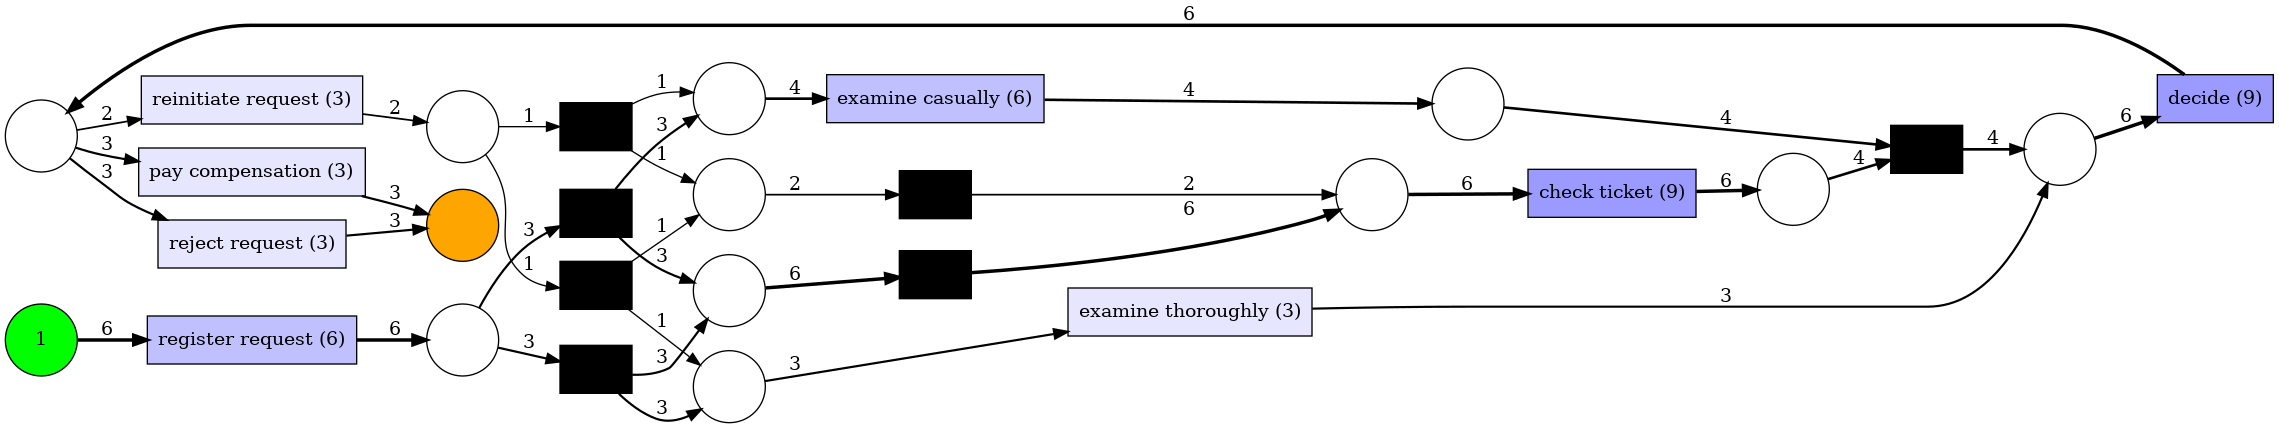

In [57]:
# Miner
petri_net, initial_marking, final_marking = heuristics_miner.apply(log)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# View
pn_visualizer.view(gviz)

## 4.3 Inductive Miner

- Can handle invisible tasks
- Model is sound
- Most used process mining algorithm

Process Mining for Python (PM4Py) offers an implementation of the inductive miner (IM), of the inductive miner infrequent (IMf), and of the inductive miner directly-follows (IMd) algorithm.

Variant | Description
------ | ------
IM | Produces a model with perfect replay fitness.
IMf | Produces a more precise model, without fitness guarantees, by eliminating some behavior (using a noise threshold).
IMd | A variant of inductive miner that considers only the directly-follows graph, for maximum performance. However, replay fitness guarantees are lost.

The basic idea of Inductive Miner is about detecting a 'cut' in the log (e.g. sequential cut, parallel cut, concurrent cut and loop cut) and then recur on sublogs, which were found applying the cut, until a base case is found. The Directly-Follows variant avoids the recursion on the sublogs but uses the Directly Follows graph.

Inductive miner models usually make extensive use of hidden transitions, especially for skipping/looping on a portion on the model. Furthermore, each visible transition has a unique label (there are no transitions in the model that share the same label).

Two process models can be derived: Petri Net and Process Tree.



```python
# Simplified Interface
petri_net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log) 
pm4py.save_vis_petri_net(petri_net, initial_marking, final_marking, 'output/inductive_miner.png')
pm4py.view_petri_net(petri_net, initial_marking, final_marking, format='png') 
```

### 4.3.1 Inductive Miner (IM)

#### Performance

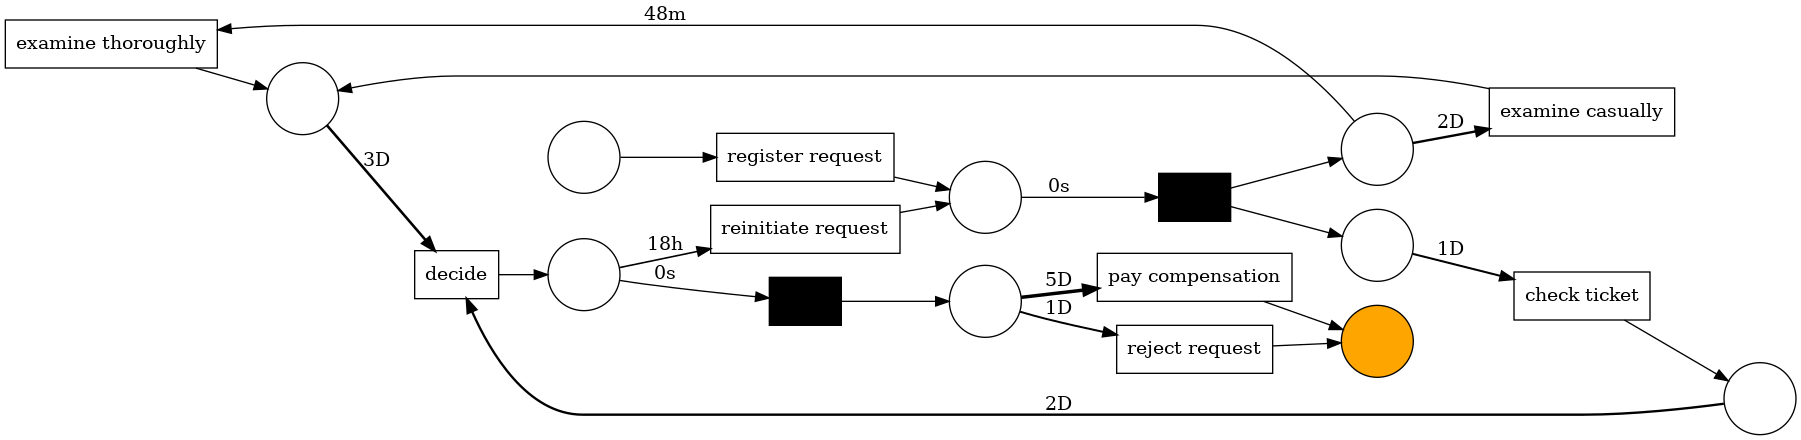

In [58]:
# Miner
petri_net, marking, final_marking = inductive_miner.apply(log, variant=inductive_miner.IM)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.PERFORMANCE, 
                           log = log)

# Save
pn_visualizer.save(gviz, 'output/IM_performance_petri.png')

# View
pn_visualizer.view(gviz)

#### Frequency

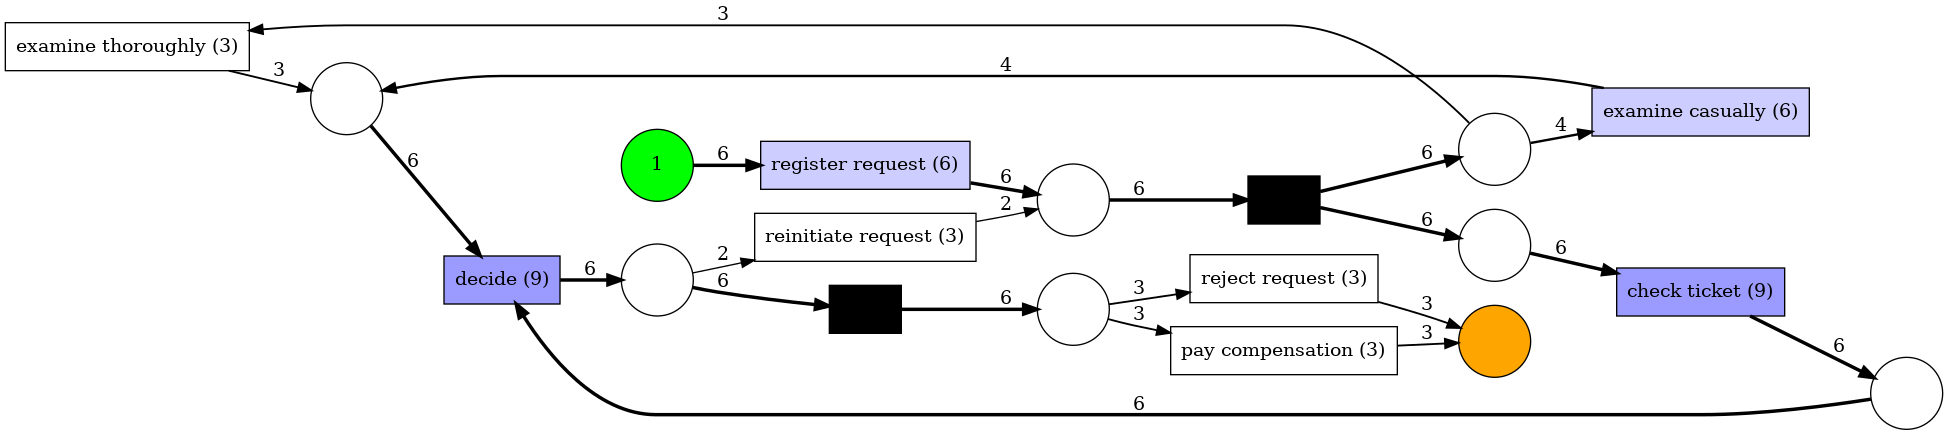

In [59]:
# Miner
petri_net, initial_marking, final_marking = inductive_miner.apply(log, variant=inductive_miner.IM)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.FREQUENCY, 
                           log = log)

# Save
pn_visualizer.save(gviz, 'output/IM_frequency_petri.png')

# View
pn_visualizer.view(gviz)

#### Process Tree

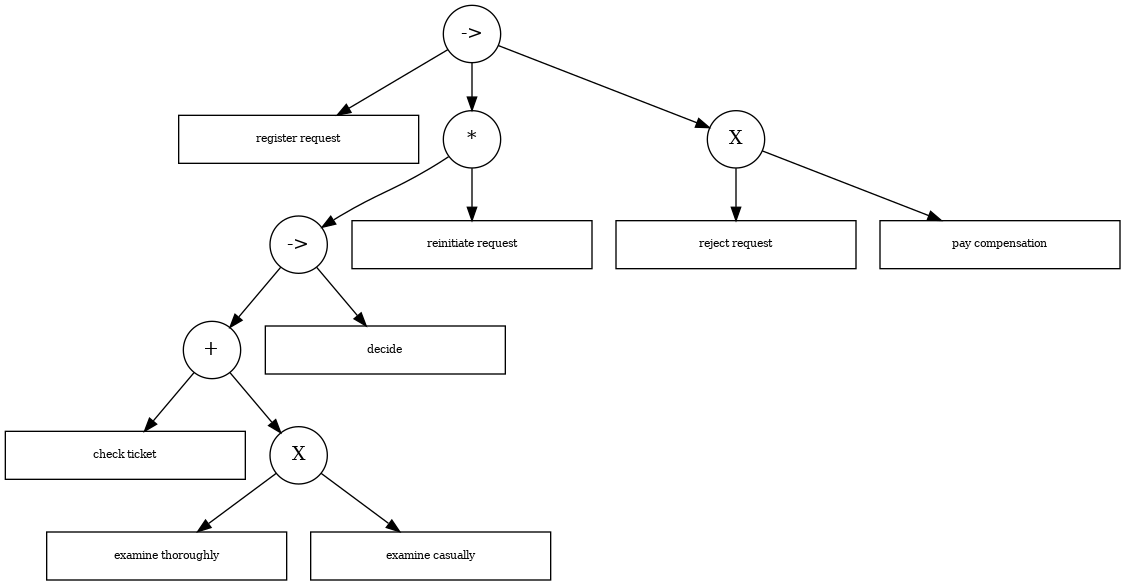

In [60]:
# Miner
tree = inductive_miner.apply_tree(log, variant=inductive_miner.IM)

# GraphViz
gviz = pt_visualizer.apply(tree)

# Save
pn_visualizer.save(gviz, 'output/IM_tree.png')

# View
pt_visualizer.view(gviz)

### 4.3.2 Inductive Miner infrequent (IMf)

The noise threshold (between 0.0 and 1.0) has 0.2 as default value.

#### Performance

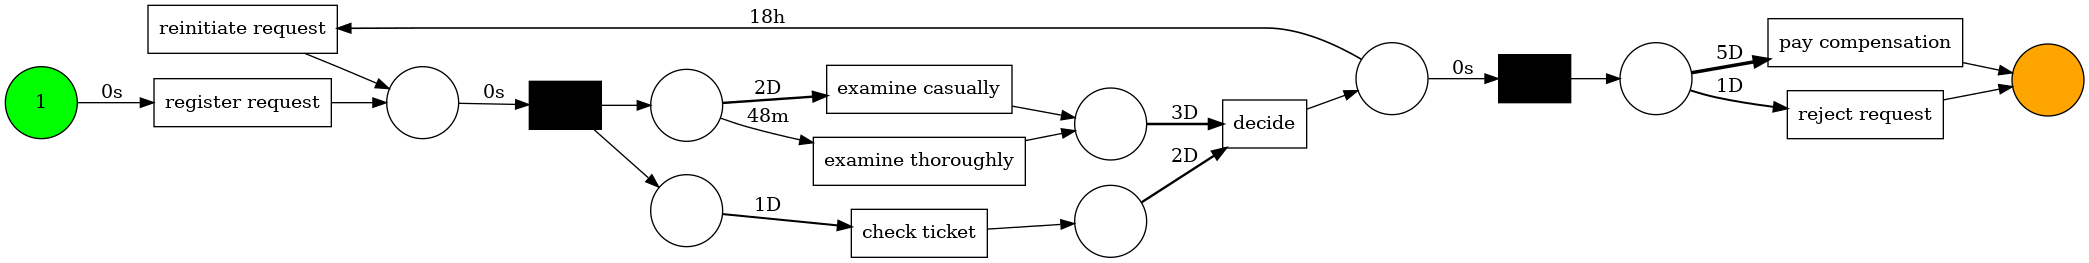

In [61]:
# Miner
petri_net, initial_marking, final_marking = inductive_miner.apply(log, variant=inductive_miner.IMf)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.PERFORMANCE, 
                           log = log)

# Save
pn_visualizer.save(gviz, 'output/IMf_performance_petri.png')

# View
pn_visualizer.view(gviz)

#### Frequency

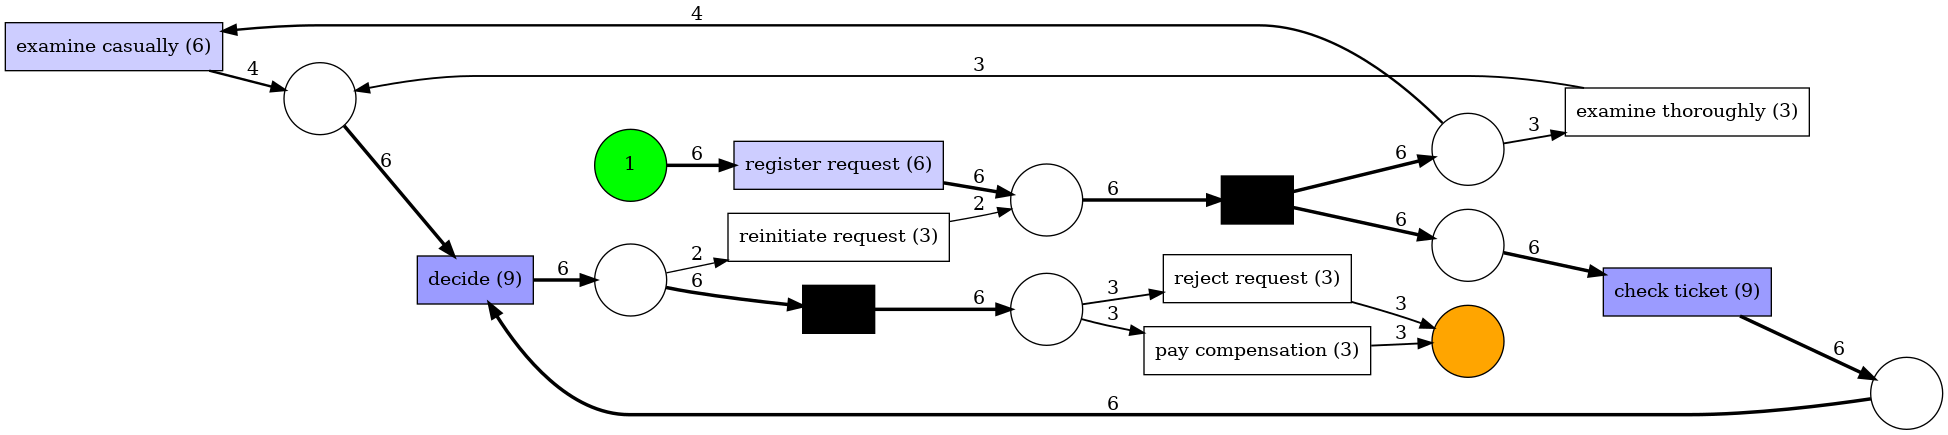

In [62]:
# Miner
petri_net, initial_marking, final_marking = inductive_miner.apply(log, variant=inductive_miner.IMf)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.FREQUENCY, 
                           log = log)

# Save
pn_visualizer.save(gviz, 'output/IMf_frequency_petri.png')

# View
pn_visualizer.view(gviz)

#### Interactive

In [63]:
def perti_net(noise_threshold, decoration):
    
    # Parameters
    parameters = inductive_miner.Variants.IMf.value.Parameters
    
    # Miner
    petri_net, initial_marking, final_marking = inductive_miner.apply(log, variant=inductive_miner.IMf)
    
    # GraphViz
    if decoration == 'Frequency':
        variant = pn_visualizer.Variants.FREQUENCY
    elif decoration == 'Performance':
        variant = pn_visualizer.Variants.PERFORMANCE
    else:
        variant = pn_visualizer.Variants.WO_DECORATION
    
    # GraphViz
    gviz = pn_visualizer.apply(
        petri_net, initial_marking, final_marking, 
        parameters={parameters.NOISE_THRESHOLD: noise_threshold},
                    variant = variant, 
                    log = log
    )
    
    # Save
    pn_visualizer.save(gviz, 'output/temp.png')
    
    # View
    vis_utils.view_image_in_jupyter('output/temp.png')

interact(
    perti_net, 
    noise_threshold = widgets.FloatSlider(
        value=0.2, min=0, max=1, step=0.01, description='Noise:', 
        disabled=False, continuous_update=False, orientation='horizontal', 
        readout=True, readout_format='.2f'
    ),
    decoration = widgets.RadioButtons(
        options=['Frequency', 'Performance', 'Default'], 
        value='Frequency', 
        description='Decoration:', 
        disabled=False
    ),
)

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Noise:', max=1.0, step=0.01…

<function __main__.perti_net(noise_threshold, decoration)>

### 4.3.3 Inductive Miner directly-follows (IMd)

#### Performance

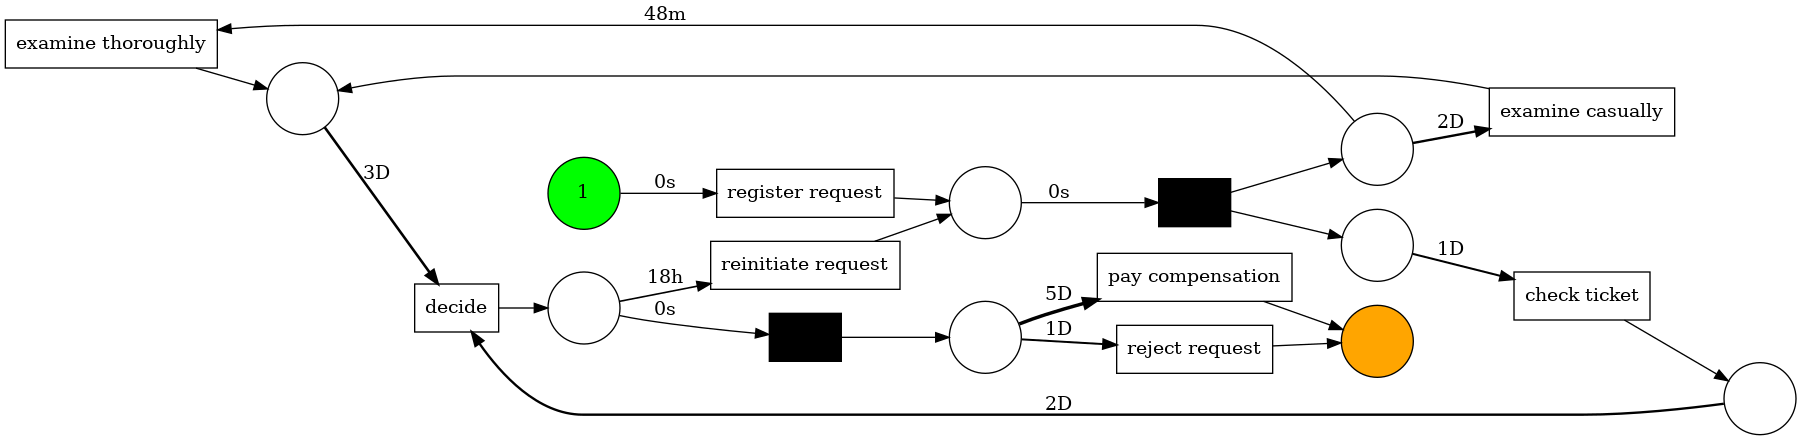

In [64]:
# Miner
net, initial_marking, final_marking = inductive_miner.apply(log, variant=inductive_miner.IMd)

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.PERFORMANCE, 
                           log = log)

# Save
pn_visualizer.save(gviz, 'output/IMd_performance_petri.png')

# View
pn_visualizer.view(gviz)

#### Frequency

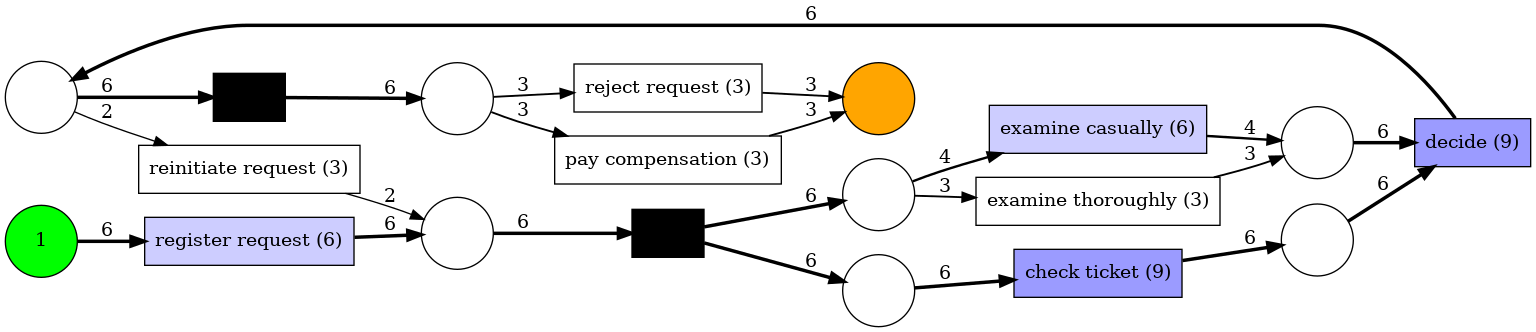

In [65]:
# Miner
net, initial_marking, final_marking = inductive_miner.apply(log, variant=inductive_miner.IMd)

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.FREQUENCY, 
                           log = log)

# Save
pn_visualizer.save(gviz, 'output/IMd_frequency_petri.png')

# View
pn_visualizer.view(gviz)

#### Process Tree

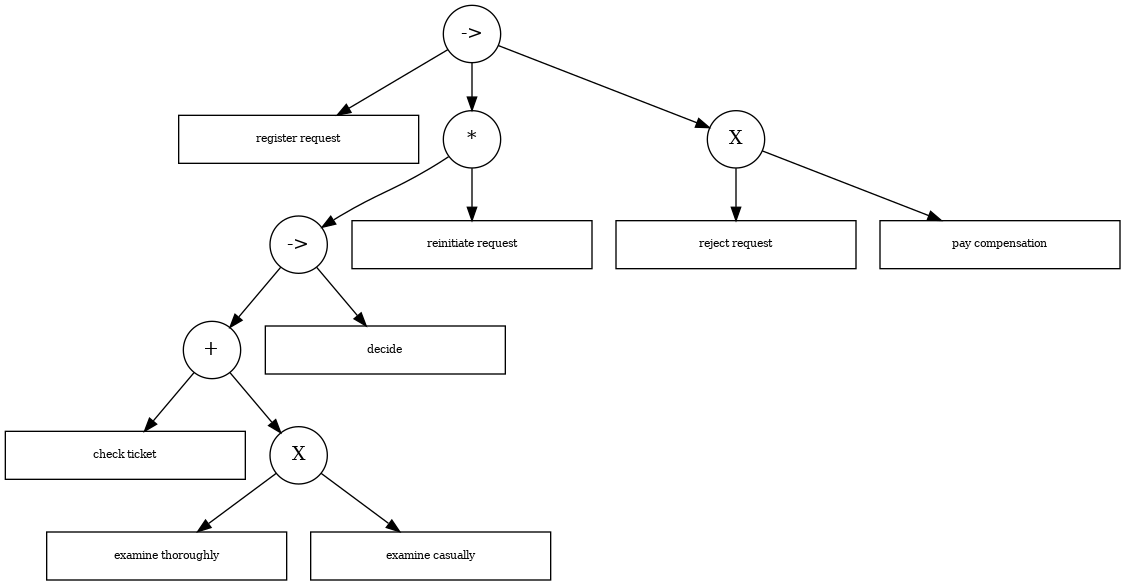

In [66]:
# Miner
tree = inductive_miner.apply_tree(log, variant=inductive_miner.IMd)

# GraphViz
gviz = pt_visualizer.apply(tree)

# Save
pn_visualizer.save(gviz, 'output/IMd_tree.png')

# View
pt_visualizer.view(gviz)

#### Convert "Process tree" to "Petri net"

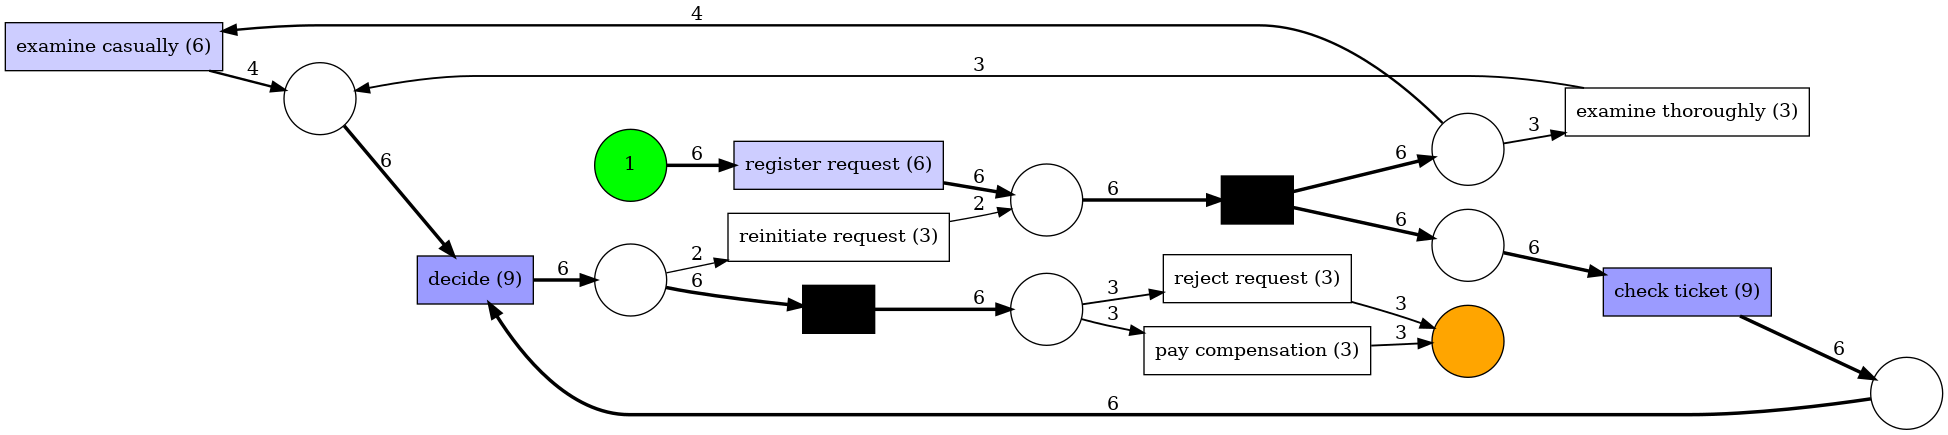

In [67]:
# Convert the process tree to a petri net
net, initial_marking, final_marking = pt_converter.apply(tree)

# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# View
pn_visualizer.view(gviz)

## 4.4 Directly-Follows Graph

Directly-Follows graphs are graphs where the nodes represent the events/activities in the log and directed edges are present between nodes if there is at least a trace in the log where the source event/activity is followed by the target event/activity. On top of these directed edges, it is easy to represent metrics like frequency (counting the number of times the source event/activity is followed by the target event/activity) and performance (some aggregation, for example, the mean, of time inter-lapsed between the two events/activities).

```python
# Simplified Interface
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.save_vis_dfg(dfg, initial_marking, final_marking, 
                   file_path='output/dfg.png', log=log) # svg
pm4py.view_dfg(dfg, start_activities, end_activities, 
               format='png', log=log)
```

### 4.4.1 Directly-Follows Graph

#### Performance

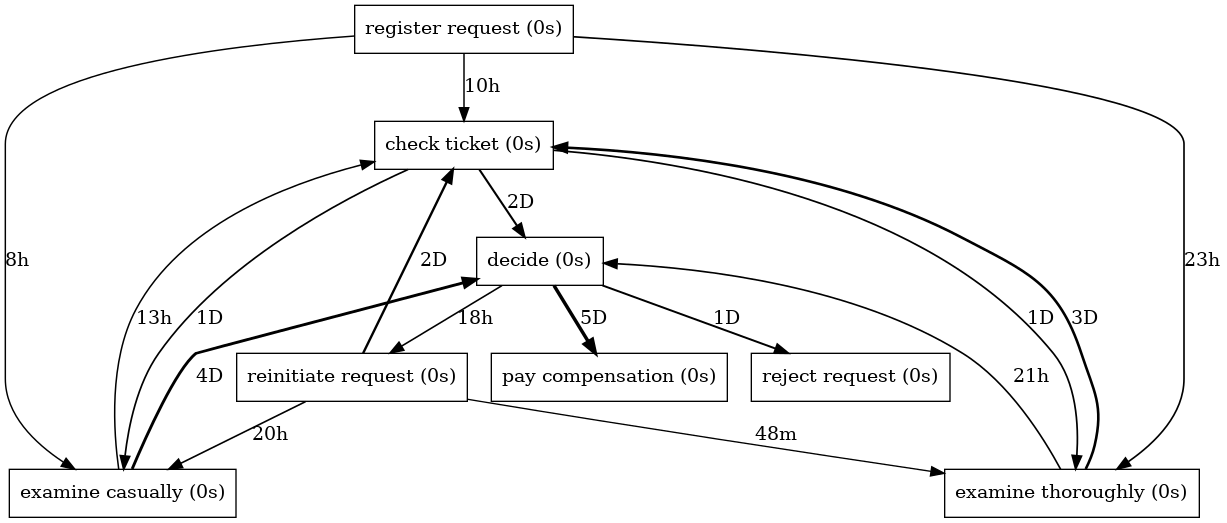

In [68]:
# Miner
dfg = dfg_discovery.apply(log, variant = dfg_discovery.Variants.PERFORMANCE)

# GraphViz
gviz = dfg_visualization.apply(dfg, log = log, variant = dfg_visualization.Variants.PERFORMANCE)

# Save
dfg_visualization.save(gviz, 'output/dfg_performance.png')

# View
dfg_visualization.view(gviz)

In [69]:
# Reproducing results from the log_csv ########################################

# Duration in days
duration_D = activity_duration(log_csv, 'case_id', 'activity', 'timestamp', duration='D')\
.groupby(by = ['event_from', 'event_to']).mean('duration (D)')\
.reset_index()
duration_D['duration (D)'] = np.floor(duration_D['duration (D)']).astype(int)

# Duration in hours
duration_h = activity_duration(log_csv, 'case_id', 'activity', 'timestamp', duration='h')\
.groupby(by = ['event_from', 'event_to']).mean('duration (h)')\
.reset_index()
duration_h['duration (h)'] = np.floor(duration_h['duration (h)']).astype(int)

# Duration in minutes
duration_m = activity_duration(log_csv, 'case_id', 'activity', 'timestamp', duration='m')\
.groupby(by = ['event_from', 'event_to']).mean('duration (m)')\
.reset_index()
duration_m['duration (m)'] = np.floor(duration_m['duration (m)']).astype(int)

# Merge durations
Dhm = pd.merge(
    pd.merge(duration_D,
             duration_h,
             on=['event_from', 'event_to']
            ),
    duration_m,
    on=['event_from', 'event_to']
)

# Select durations
duration_list = list()
for row in Dhm.itertuples(index=False):
    if row._2 >= 1:
        duration_list.append(f'{row._2}D')
    elif row._3 >= 1:
        duration_list.append(f'{row._3}h')
    else:
        duration_list.append(f'{row._4}m')
Dhm['duration'] = duration_list

# View durations
Dhm[['event_from', 'event_to', 'duration']]

,event_from,event_to,duration
0,check ticket,decide,2D
1,check ticket,examine casually,1D
2,check ticket,examine thoroughly,1D
3,decide,pay compensation,5D
4,decide,reinitiate request,18h
5,decide,reject request,1D
6,examine casually,check ticket,13h
7,examine casually,decide,4D
8,examine thoroughly,check ticket,3D
9,examine thoroughly,decide,21h


#### Frequency

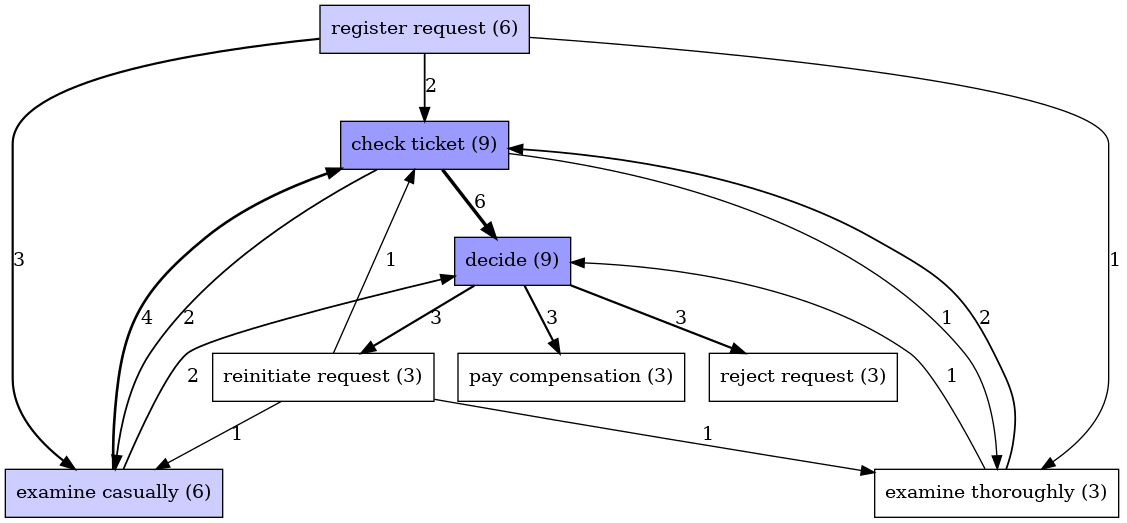

In [70]:
# Miner
dfg = dfg_discovery.apply(log, variant = dfg_discovery.Variants.FREQUENCY)

# GraphViz
gviz = dfg_visualization.apply(dfg, log = log, variant = dfg_visualization.Variants.FREQUENCY)

# Save
dfg_visualization.save(gviz, 'output/dfg_frequency.png')

# View
dfg_visualization.view(gviz)

In [71]:
# Reproducing results from the log_csv ########################################

pd.DataFrame(log_csv.activity.value_counts())

,activity
check ticket,9
decide,9
examine casually,6
register request,6
reinitiate request,3
pay compensation,3
reject request,3
examine thoroughly,3


In [72]:
# Reproducing results from the log_csv ########################################

dfg_frequency_table(dfg_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp')).astype(int)

frequency
event_from         event_to                     
register request   examine casually            3
                   check ticket                2
                   examine thoroughly          1
examine casually   check ticket                4
                   decide                      2
check ticket       examine casually            2
                   decide                      6
                   examine thoroughly          1
decide             reinitiate request          3
                   pay compensation            3
                   reject request              3
reinitiate request examine casually            1
                   check ticket                1
                   examine thoroughly          1
examine thoroughly check ticket                2
                   decide                      1

### 4.4.2 Convert "Directly-Follows Graph" to "Petri Net"

#### Performance

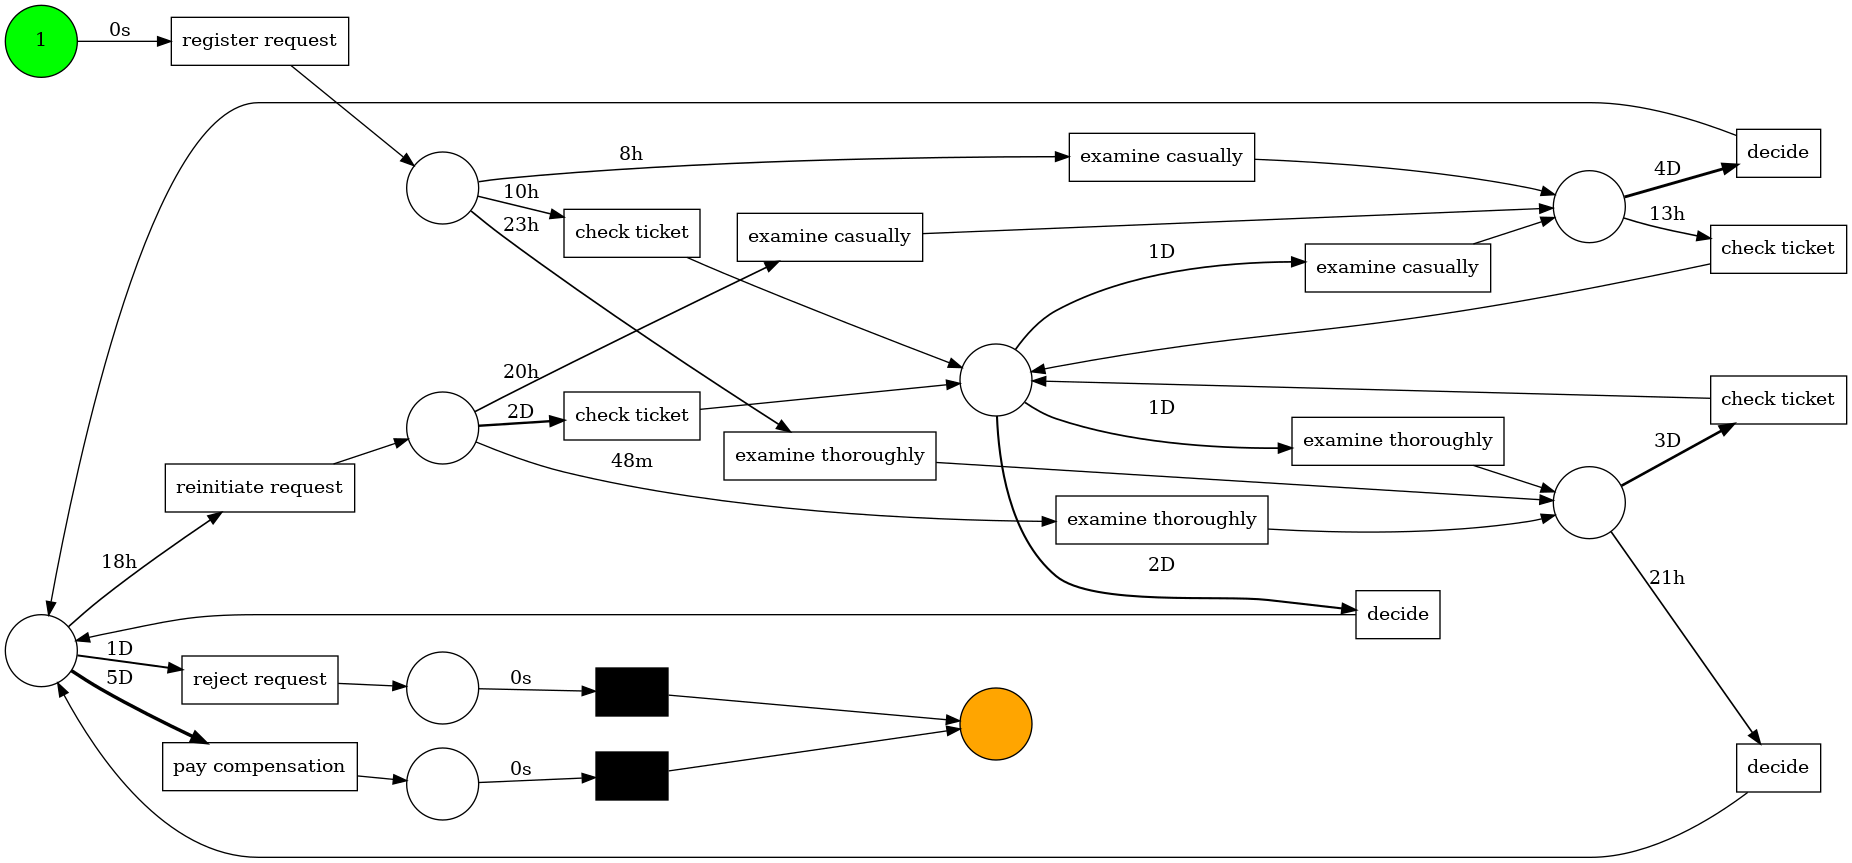

In [73]:
# Miner
dfg = dfg_discovery.apply(log, variant = dfg_discovery.Variants.PERFORMANCE)

# Convert
net, initial_marking, final_marking = dfg_converter.apply(dfg)

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           variant = pn_visualizer.Variants.PERFORMANCE, 
                           log = log)

# Save
pn_visualizer.save(gviz, 'output/dfg_performance_petri.png')

# View
pn_visualizer.view(gviz)

#### Frequency

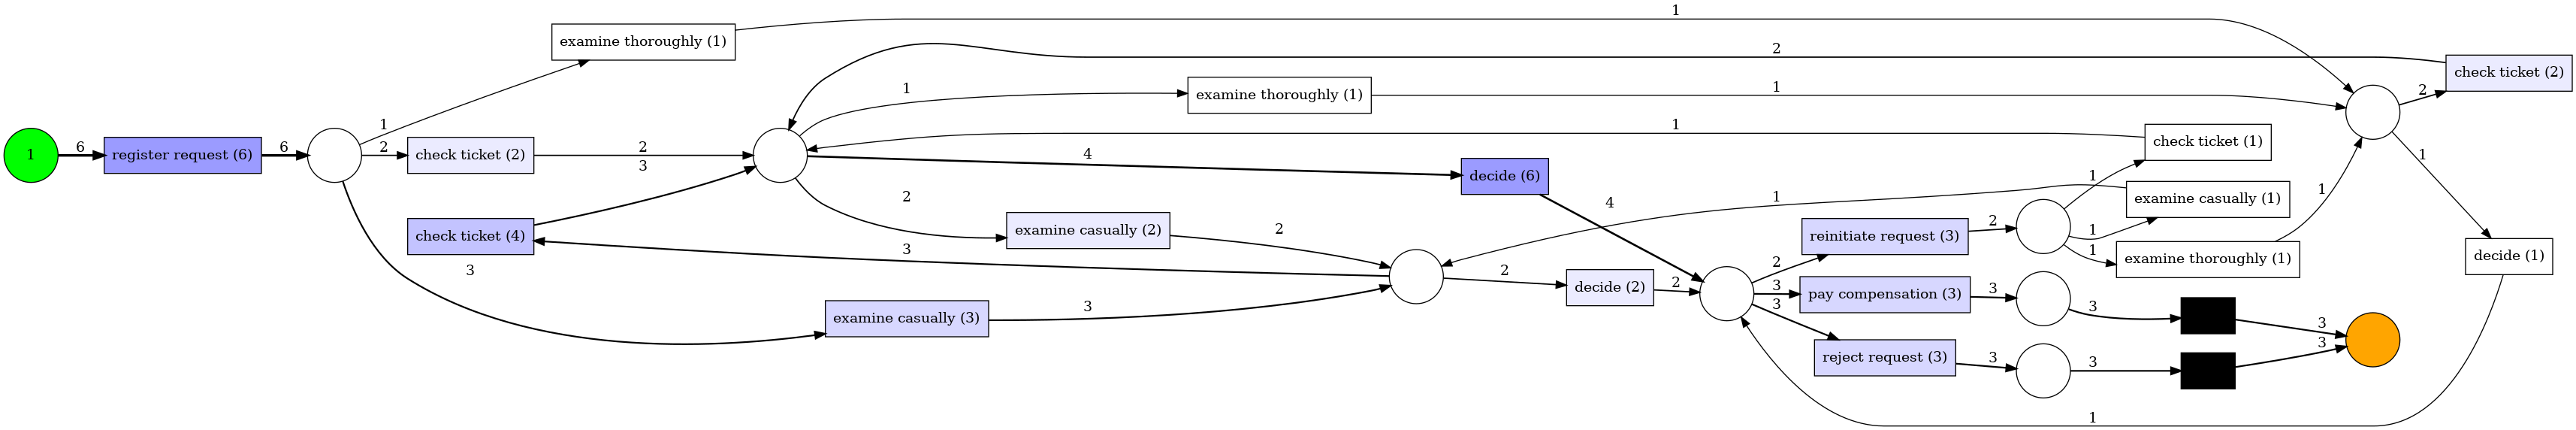

In [74]:
# Miner
dfg = dfg_discovery.apply(log, variant = dfg_discovery.Variants.FREQUENCY)

# Convert
net, initial_marking, final_marking = dfg_converter.apply(dfg)

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.FREQUENCY, 
                           log = log)

# Save
pn_visualizer.save(gviz, 'output/dfg_frequency_petri.png')

# View
pn_visualizer.view(gviz)

## 5. Conformance checking

## 5.1 Token-based replay

In PM4Py there is an implementation of a token replayer that is able to go across hidden transitions (calculating shortest paths between places) and can be used with any Petri net model with unique visible transitions and hidden transitions. When a visible transition needs to be fired and not all places in the preset are provided with the correct number of tokens, starting from the current marking it is checked if for some place there is a sequence of hidden transitions that could be fired in order to enable the visible transition. The hidden transitions are then fired and a marking that permits to enable the visible transition is reached.

The following example shows how to apply token-based replay on a log and a Petri net. First, the log is loaded. Then, the Alpha Miner is applied in order to discover a Petri net. Eventually, the token-based replay is applied. The output of the token-based replay, stored in the variable `replayed_traces`, contains for each trace of the log:

- **trace_is_fit**: boolean value (True/False) that is true when the trace is according to the model.
- **activated_transitions**: list of transitions activated in the model by the token-based replay.
- **reached_marking**: marking reached at the end of the replay.
- **missing_tokens**: number of missing tokens.
- **consumed_tokens**: number of consumed tokens.
- **remaining_tokens**: number of remaining tokens.
- **produced_tokens**: number of produced tokens. 

In [75]:
# Event Log
log = xes_importer.apply(os.path.join('log', 'running-example.xes'))

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

In [76]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log)

In [77]:
# Token Replay
replayed_traces = token_replay.apply(log, petri_net, initial_marking, final_marking)

# Replayed Traces
pd.DataFrame(replayed_traces)

,trace_is_fit,trace_fitness,activated_transitions,reached_marking,enabled_transitions_in_marking,transitions_with_problems,missing_tokens,consumed_tokens,remaining_tokens,produced_tokens
0,True,1.0,"[register request, examine thoroughly, check t...",{end: 1},{},[],0,7,0,7
1,True,1.0,"[register request, check ticket, examine casua...",{end: 1},{},[],0,7,0,7
2,True,1.0,"[register request, examine casually, check tic...",{end: 1},{},[],0,12,0,12
3,True,1.0,"[register request, check ticket, examine thoro...",{end: 1},{},[],0,7,0,7
4,True,1.0,"[register request, examine casually, check tic...",{end: 1},{},[],0,17,0,17
5,True,1.0,"[register request, examine casually, check tic...",{end: 1},{},[],0,7,0,7


The token-based replay supports different parameters:

Parameter |	Meaning
----- | -----
**Parameters.CONSIDER_REMAINING_IN_FITNESS** | If the parameter is set to **True** (as default) trace is considered fit if it does not lead to any missing/remaining token in the model.
**Parameters.TRY_TO_REACH_FINAL_MARKING_THROUGH_HIDDEN** | When the replay of the trace is completed, try to reach the final marking through invisible transitions (default: **True**)
**Parameters.STOP_IMMEDIATELY_UNFIT** | Stops the replay immediately when a missing token needs to be inserted (default: **False**)
**Parameters.WALK_THROUGH_HIDDEN_TRANS** | Enables, in general, the traversal of invisible transitions (default: **True**)
**Parameters.CLEANING_TOKEN_FLOOD** | Limits the token flooding problem by an apposite algorithm (default: **False**)
**Parameters.RETURN_NAMES** | Return the transitions names, not the transition object, in the list of activated transitions for a trace.
**Parameters.ACTIVITY_KEY** | Establish the attribute of a trace to be used during the replay (default: **concept:name**), 

In [78]:
# Parameters
parameters = token_replay.Variants.TOKEN_REPLAY.value.Parameters

# Token Replay
replayed_traces = token_replay.apply(
    log, petri_net, initial_marking, final_marking,
    parameters = {
        parameters.CONSIDER_REMAINING_IN_FITNESS: False, 
        parameters.STOP_IMMEDIATELY_UNFIT: True, 
        parameters.WALK_THROUGH_HIDDEN_TRANS: False, 
        parameters.RETURN_NAMES: False,
    }
)

# Replayed Traces
pd.DataFrame(replayed_traces)

,trace_is_fit,trace_fitness,activated_transitions,reached_marking,enabled_transitions_in_marking,transitions_with_problems,missing_tokens,consumed_tokens,remaining_tokens,produced_tokens
0,True,1.0,"[register request, examine thoroughly, check t...",{end: 1},{},[],0,7,0,7
1,True,1.0,"[register request, check ticket, examine casua...",{end: 1},{},[],0,7,0,7
2,True,1.0,"[register request, examine casually, check tic...",{end: 1},{},[],0,12,0,12
3,True,1.0,"[register request, check ticket, examine thoro...",{end: 1},{},[],0,7,0,7
4,True,1.0,"[register request, examine casually, check tic...",{end: 1},{},[],0,17,0,17
5,True,1.0,"[register request, examine casually, check tic...",{end: 1},{},[],0,7,0,7


### 5.1.1 Happy Flow

In [79]:
# Create log
log = pm4py.format_dataframe(
    log_csv,
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

In [80]:
# Miner
net, initial_marking, final_marking = alpha_miner.apply(log)

In [81]:
# Conformance cheching
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)

In [82]:
# Result (for each trace / case)
df_replayed_traces = pd.DataFrame(replayed_traces)
df_replayed_traces['activated_transitions'] = [len(_) for _ in df_replayed_traces.activated_transitions]
df_replayed_traces.iloc[:, [0, 1, 2, 6, 7, 8, 9]]

,trace_is_fit,trace_fitness,activated_transitions,missing_tokens,consumed_tokens,remaining_tokens,produced_tokens
0,True,1.0,5,0,7,0,7
1,True,1.0,5,0,7,0,7
2,True,1.0,9,0,12,0,12
3,True,1.0,5,0,7,0,7
4,True,1.0,13,0,17,0,17
5,True,1.0,5,0,7,0,7


### 5.1.2 Filtered Log

In [83]:
# Create filtered/partial log: drop activity 'decide'
filtered_log = pm4py.format_dataframe(
    log_csv[~log_csv.activity.isin(['decide'])],
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

In [84]:
# Miner
net, initial_marking, final_marking = alpha_miner.apply(filtered_log)

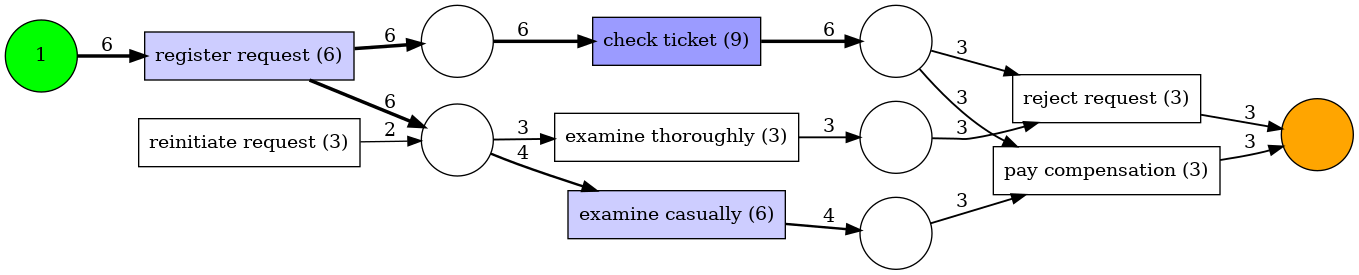

In [85]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}

# GraphViz
gviz = pn_visualizer.apply(
    net, initial_marking, final_marking,
    parameters = parameters, 
    variant = pn_visualizer.Variants.FREQUENCY, 
    log = filtered_log
)

# View
pn_visualizer.view(gviz)

In [86]:
# Conformance checking
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)

In [87]:
# Result (for each trace / case)
df_replayed_traces = pd.DataFrame(replayed_traces)
#df_replayed_traces['activated_transitions'] = [len(_) for _ in df_replayed_traces.activated_transitions]
df_replayed_traces.iloc[:, [0, 1, 2, 6, 7, 8, 9]]

,trace_is_fit,trace_fitness,activated_transitions,missing_tokens,consumed_tokens,remaining_tokens,produced_tokens
0,True,1.000000,"[register request, examine thoroughly, check t...",0,6,0,6
1,True,1.000000,"[register request, check ticket, examine casua...",0,6,0,6
2,False,0.826389,"[register request, examine casually, check tic...",1,8,2,9
3,True,1.000000,"[register request, check ticket, examine thoro...",0,6,0,6
4,False,0.641667,"[register request, examine casually, check tic...",3,10,5,12
5,True,1.000000,"[register request, examine casually, check tic...",0,6,0,6


## 5.2 Diagnostics (TBR)

# 6. Throughput analysis/bottleneck detection

**Resources:**
- PM4PY [documentation](https://pm4py.fit.fraunhofer.de/documentation)
- PM4Py [documentation](http://pm4py.pads.rwth-aachen.de/documentation/) (older version?)
- Towards Data Science story [Introduction to Process Mining](https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5)
- Process Mining for Python on [Youtube](https://www.youtube.com/channel/UCRcgOKrDsntrTI78RXXliuw/videos)
- Wikipedia page [process mining](https://en.wikipedia.org/wiki/Process_mining)
- Wikipedia page [Petri net](https://en.wikipedia.org/wiki/Petri_net)
- Alpha Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15636)
- Heuristics Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15639)
- Inductive Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15642)
- Workflow Net and Soundness [video](https://www.coursera.org/lecture/process-mining/2-5-workflow-nets-and-soundness-tBnqo)
- Process Mining Manifestio ([pdf-document](https://www.win.tue.nl/ieeetfpm/downloads/Process%20Mining%20Manifesto.pdf))
- Data Mining [Event Logs](https://data.4tu.nl/search?q=BPI)
